## Google Maps | Location History Analysis

<img src="https://images.unsplash.com/photo-1548345680-f5475ea5df84?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2073&q=80" alt="Google Maps image" width="500" style="margin-left:0"/>    

Credits: Photo by <a href="https://unsplash.com/@hjkp?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">henry perks</a> on <a href="https://unsplash.com/s/photos/google-maps?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

*Project summary:*
In my [Samsung Health project](https://github.com/MargotMarchais/Samsung_Health_analysis), I analyzed several years of my pedometer data (number of steps and calories burned). Yet, these data do not include all my workout activities. For instance, swimming and dance classes are not present in the data because I own a smartphone (i.e. not a smartwatch). Thus, the analysis of my Samsung Health data underestimates my total activity workouts by focusing only on activities that can be easiy recorded with a smartphone like running and hiking.

To bridge the gap, I used a second data source: Google Maps Location History data. With those data, I could identify the places where I used to go swimming and dancing, and the times I went there. To do so, I imported dozens of JSON files and loaded them into 2 Python dataframes. The aim of the project is to track down the number of times I went to the swimming pool / dance studio and the average duration of my workouts.

## TOC:
* [1. Import the relevant packages](#1)   
* [2. Convert dozens of JSON files into 2 Python lists](#2)
* [3. Transform the lists into Pandas dataframes](#3)
* [4. Clean data](#4)
* [5. Enrich data](#5)
 * [5.1. Dates and durations](#5.1)
 * [5.2. Add manually names to addresses with no Google Maps name](#5.2)
 * [5.3. Extract City, Zipcode and Country information](#5.3)
* [6. Export the raw data to csv](#6)
* [7. Data visualization and insights](#7)
* [7.1 Number of times I did swimming and dancing workouts](#7.1)
* [7.2 Workout durations](#7.2)
* [8. Conclusion](#8)
* [8.1 Key learnings](#8.1)
* [8.2 Next steps](#8.2)


## Step 1: Import the relevant packages / modules <a class="anchor" id="1"></a>

In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import string

## Step 2 : Convert dozens of JSON files into 2 Python lists <a class="anchor" id="2"></a>

This step is without any doubt the most difficult part in the project. Indeed, when downloaded, Google Maps data are:
- located in different subfolders (one per year)
- stored across multiple files (I received 72 files in total)
- and written in deep-nested JSON format (which was a new format to me)

To import the data, I tackled the places visited and the activity segments separately (2 chunks of code, see below).

Note: For this step, I am very grateful to the software engineer [Maksym Kozlenko](https://betterprogramming.pub/loading-location-history-places-from-google-timeline-into-pandas-and-csv-c26cb0ac5e89) who shared his tricks to import all JSON data into a single file. I reused the code and enriched it to also take into consideration the activity segments (see below).

In [2]:
# Objective: Import all the JSON data related to place visited (respectively activities) into a single file

# Provide the path to my Google Location History takeout file
history_data_file = "C:/Users/margo/Documents/Documents/Formation/Github/Google_Maps_Location_History/takeout-20221120T190757Z-001.zip"

# Store all places visited into the array called "place_visits", and all activities into the array called "activity_segments".
# For now, we set both arrays as empty.
place_visits = []
activity_segments = []

# Google Maps data are obtained through a zip file (cf. folder "takeout-20221120T190757Z-001" mentioned in the history_data_file variable). 
    # In this zip file, there are many folders and files that we want to open and read their information.
with ZipFile(history_data_file) as myzip:
    for file in myzip.filelist[:]:
        filename = file.filename
        
        # we process all files in the "Semantic Location History" directory (this is where all the JSON files are located)
        if "Semantic Location History" in filename:
            history_json = json.load(myzip.open(filename))  # We load every JSON file found in the zip folder

            # The JSON files always start with the "timelineObjects" JSON object
            for timeline_object in history_json["timelineObjects"]:
               
            # Step 1 : Extract information about places visited
                # placeVisit is one of the most important Google Maps objects. It is located in timelineObjects.
                if "placeVisit" in timeline_object:
                    place_visit_json = timeline_object["placeVisit"]
                    
                    # skip places without geographical coordinates
                    if not "location" in place_visit_json or not "latitudeE7" in place_visit_json["location"]:
                        continue
                    
                    # We specify each column we want to extract for our future places_visit dataframe. 
                        # Note: We identify them thanks to their position in the JSON file.
                    place_visit = {
                        "placeId": place_visit_json["location"]["placeId"],
                        "locationConfidence": place_visit_json["location"]["locationConfidence"],
                        "startTimestamp": place_visit_json["duration"]["startTimestamp"],
                        "endTimestamp": place_visit_json["duration"]["endTimestamp"],
                        "placeVisitImportance": place_visit_json["placeVisitImportance"],
                        "placeVisitType": place_visit_json["placeVisitType"],
                        "latitudeE7": place_visit_json["location"]["latitudeE7"],
                        "longitudeE7": place_visit_json["location"]["longitudeE7"],
                    }
                    
                    # Below, we treat differently special columns like centerLatE7, centerLngE7, name and address
                        # Indeed, these columns do not always contain information so we offer the possibility that values are Null ("None")
                        
                    # Optional columns in the timelineObjects object
                    for optional_field in ["centerLatE7", "centerLngE7"]:
                        if optional_field in place_visit_json:
                            place_visit[optional_field] = place_visit_json[optional_field] # path to find the information if it exists
                        else:
                            place_visit[optional_field] = None # in case it does not exist, we set it to None
                    
                    # Optional columns in the timelineObjects / location object
                    for optional_field in ["name", "address"]:
                        if optional_field in place_visit_json["location"]:
                            place_visit[optional_field] = place_visit_json["location"][optional_field] # path to find the information if it exists
                        else:
                            place_visit[optional_field] = None # in case it does not exist, we set it to None
                        
                    # Final step: Concatenate the information from all files into the array place_visits
                    place_visits.append(place_visit)
                    
                    
                # Step 2 : Extract information from activities performed
                elif "activitySegment" in timeline_object:
                    activity_segment_json = timeline_object["activitySegment"]      
                    
                    # # the future columns of our activity_segments dataframe. 
                        # We identify them thanks to their position in the JSON file.
                    activity_segment = {
                        "activityType": activity_segment_json["activityType"],
                        "startlocation_lat": activity_segment_json["startLocation"]["latitudeE7"],
                        "startlocation_long": activity_segment_json["startLocation"]["longitudeE7"],
                        "endlocation_lat": activity_segment_json["endLocation"]["latitudeE7"],
                        "endlocation_long": activity_segment_json["endLocation"]["longitudeE7"],
                        "startTimestamp": activity_segment_json["duration"]["startTimestamp"],
                        "endTimestamp": activity_segment_json["duration"]["endTimestamp"]
                    }
                    
                    # Optional columns in the timelineObjects object
                    for optional_field in ["distance", "confidence", "waypointPath", "simplifiedRawPath", "transitPath"]:
                        if optional_field in activity_segment_json:
                            activity_segment[optional_field] = activity_segment_json[optional_field]
                        else:
                            activity_segment[optional_field] = None
                   
                # Final step: Concatenate the information from all files into the array activity segments
                activity_segments.append(activity_segment)

In [3]:
# Glimpse of what the list place_visits contains (e.g. the first element in the list)
place_visits[0]

{'placeId': 'ChIJzTpDSwN75kcRriD8S2b3Z3M',
 'locationConfidence': 34.114983,
 'startTimestamp': '2022-11-04T07:12:00.170Z',
 'endTimestamp': '2022-11-04T07:15:08.347Z',
 'placeVisitImportance': 'MAIN',
 'placeVisitType': 'SINGLE_PLACE',
 'latitudeE7': 488284956,
 'longitudeE7': 22270113,
 'centerLatE7': 488299363,
 'centerLngE7': 22241236,
 'name': 'Pont de Sèvres',
 'address': '92310 Boulogne-Billancourt, France'}

In [4]:
# Glimpse of what the activity_segments contains (e.g. the first element in the list)
activity_segments[0]

{'activityType': 'WALKING',
 'startlocation_lat': 488376970,
 'startlocation_long': 22999995,
 'endlocation_lat': 488311020,
 'endlocation_long': 22859879,
 'startTimestamp': '2022-11-04T06:39:59.729Z',
 'endTimestamp': '2022-11-04T06:54:29.090Z',
 'distance': 1312,
 'confidence': 'MEDIUM',
 'waypointPath': {'waypoints': [{'latE7': 488375244, 'lngE7': 22997310},
   {'latE7': 488381729, 'lngE7': 22987389},
   {'latE7': 488347244, 'lngE7': 22916278},
   {'latE7': 488333969, 'lngE7': 22870666},
   {'latE7': 488311195, 'lngE7': 22859570}],
  'source': 'INFERRED',
  'distanceMeters': 1657.5601221669099,
  'travelMode': 'WALK',
  'confidence': 0.9976557176935943},
 'simplifiedRawPath': {'points': [{'latE7': 488348198,
    'lngE7': 22915883,
    'accuracyMeters': 13,
    'timestamp': '2022-11-04T06:48:31.575Z'}]},
 'transitPath': None}

## Step 3: Transform the lists into Pandas dataframes <a class="anchor" id="3"></a>

As dataframes are much more convenient than lists for data analysis, we use the pandas library to perform the transformation.

In [5]:
#Transform the list into a dataframe
place_visits_df = pd.DataFrame(place_visits)
activities_df = pd.DataFrame(activity_segments)

In [6]:
# Overview of the place_visits dataframe
    # For privacy reasons, I display old data
place_visits_df.sort_values(by= "longitudeE7").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,latitudeE7,longitudeE7,centerLatE7,centerLngE7,name,address
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15T13:54:46.243Z,2017-08-15T15:06:45.530Z,MAIN,SINGLE_PLACE,483862918,-44835494,483864727,-44840673,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres..."
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15T15:09:49.427Z,2017-08-15T15:55:54.072Z,MAIN,SINGLE_PLACE,483876587,-44801565,483872117,-44804356,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134..."
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10T11:05:21.169Z,2017-08-15T12:39:04.540Z,MAIN,SINGLE_PLACE,482934855,-41780653,482348423,-44958069,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France"


In [7]:
# Overview of the activities dataframe
    # For privacy reasons, I display old data
activities_df.sort_values("startlocation_long").head(3)

,activityType,startlocation_lat,startlocation_long,endlocation_lat,endlocation_long,startTimestamp,endTimestamp,distance,confidence,waypointPath,simplifiedRawPath,transitPath
6692,RUNNING,482347212,-44959911,482934855,-41780653,2017-08-09T14:11:00.922Z,2017-08-09T14:49:30.632Z,3463.0,MEDIUM,None,"{'points': [{'latE7': 482264144, 'lngE7': -450...",None
6691,RUNNING,482347212,-44959911,482934855,-41780653,2017-08-09T14:11:00.922Z,2017-08-09T14:49:30.632Z,3463.0,MEDIUM,None,"{'points': [{'latE7': 482264144, 'lngE7': -450...",None
6690,IN_PASSENGER_VEHICLE,482348022,-44959138,482934855,-41780653,2017-08-05T17:19:04.582Z,2017-08-05T18:10:18.126Z,985989.0,HIGH,"{'waypoints': [{'latE7': 482347145, 'lngE7': -...",None,None


## Step 4: Data cleaning <a class="anchor" id="4"></a>

In [8]:
# Cleaning 1: Convert timestamp variables to datetime types
place_visits_df[["startTimestamp", "endTimestamp"]] = place_visits_df[["startTimestamp", "endTimestamp"]].apply(pd.to_datetime)
activities_df[["startTimestamp", "endTimestamp"]] = activities_df[["startTimestamp", "endTimestamp"]].apply(pd.to_datetime)

In [9]:
# Cleaning 2: Obtain the latitude and longitude in the proper format (floats)

# Step 1: Create a function to divide the Google latitude and longitude E7 by 10,000,000
def f(x): 
    return x/1E7

# Step 2: Apply the function to all geo coordinates variables
place_visits_df[["latitude", "longitude",
                 "centerLat", "centerLng"]] = place_visits_df[["latitudeE7", "longitudeE7",
                                                               "centerLatE7", "centerLngE7"]].apply(f, axis = 1)

activities_df[["startlocation_lat", "startlocation_long", 
               "endlocation_lat", "endlocation_long"]] = activities_df[["startlocation_lat", "startlocation_long", 
               "endlocation_lat", "endlocation_long"]].apply(f, axis = 1)

In [10]:
# Cleaning 3: Create clean address and name variables with no French accents and written in capital letters
place_visits_df["address_clean"] = place_visits_df["address"].str.normalize('NFKD').str.encode('ascii', 
                                                                                         errors='ignore').str.decode('utf-8').str.upper()
place_visits_df['address_clean'] = place_visits_df['address_clean'].str.replace('ROAD','RD')

place_visits_df["name_clean"] = place_visits_df["name"].str.normalize('NFKD').str.encode('ascii', 
                                                                                         errors='ignore').str.decode('utf-8').str.upper()
place_visits_df.sort_values(by = "longitudeE7").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,latitudeE7,longitudeE7,centerLatE7,centerLngE7,name,address,latitude,longitude,centerLat,centerLng,address_clean,name_clean
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,483862918,-44835494,483864727,-44840673,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,48.386473,-4.484067,"10-, 14 RUE FREGATE LA BELLE POULE, 29200 BRES...",SQUARE ALPHONSE JUIN
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,483876587,-44801565,483872117,-44804356,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,48.387212,-4.480436,"08 PLACE DU 19EME REGIMENT D'INFANTERIE, 61134...",BREST TRAIN STATION
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,482934855,-41780653,482348423,-44958069,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234842,-4.495807,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK


In [11]:
# Cleaning 4: Drop variables that are of no use
place_visits_df = place_visits_df.drop(["latitudeE7", "longitudeE7", "centerLatE7", "centerLngE7"], axis =1)
place_visits_df.sort_values(by = "longitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,centerLat,centerLng,address_clean,name_clean
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,48.386473,-4.484067,"10-, 14 RUE FREGATE LA BELLE POULE, 29200 BRES...",SQUARE ALPHONSE JUIN
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,48.387212,-4.480436,"08 PLACE DU 19EME REGIMENT D'INFANTERIE, 61134...",BREST TRAIN STATION
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234842,-4.495807,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK


## Step 5: Data enrichment <a class="anchor" id="5"></a>

### 5.1. Dates and durations <a class="anchor" id="5.1"></a>

In [12]:
# Compute durations for activities and travels
place_visits_df["duration"] = place_visits_df.endTimestamp - place_visits_df.startTimestamp
place_visits_df["duration_minutes"] = place_visits_df.duration.dt.total_seconds()/60

activities_df["duration"]= activities_df.endTimestamp - activities_df.startTimestamp
activities_df["duration_minutes"] = activities_df.duration.dt.total_seconds()/60

In [13]:
#Add year, month and date variables in the place_visits dataframe
place_visits_df["Year"] = place_visits_df["startTimestamp"].dt.year
place_visits_df["Month"] = place_visits_df["startTimestamp"].dt.month
place_visits_df["Date"] = place_visits_df["startTimestamp"].dt.date

### 5.2. Add manually names to addresses with no Google Maps name associated <a class="anchor" id="5.2"></a>

In [14]:
# Identify the addresses that do not have any name associated
no_name = place_visits_df[place_visits_df['name'].isna()]
test = no_name['address'].value_counts(ascending = False).rename_axis('address').to_frame("counts")
#test -- I do not display the results for privacy reasons

In [15]:
# Give a name to the most popular addresses that have no name associated

# Jupyter notebook public version: I do not display the code for confidentiality reasons.
# But basically, I created 2 variables :
    # name_clean : I attribute names to the addresses I lived and worked, and that Google did not recognize
    # Address_type : 'HOME' or 'WORK' or Null values
place_visits_df.sort_values("longitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,centerLat,centerLng,address_clean,name_clean,duration,duration_minutes,Year,Month,Date
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,48.386473,-4.484067,"10-, 14 RUE FREGATE LA BELLE POULE, 29200 BRES...",SQUARE ALPHONSE JUIN,0 days 01:11:59.287000,71.988117,2017,8,2017-08-15
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,48.387212,-4.480436,"08 PLACE DU 19EME REGIMENT D'INFANTERIE, 61134...",BREST TRAIN STATION,0 days 00:46:04.645000,46.077417,2017,8,2017-08-15
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234842,-4.495807,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK,5 days 01:33:43.371000,7293.722850,2017,8,2017-08-10


### 5.3. Capture City, Zipcode and Country informations <a class="anchor" id="5.3"></a>

The method used below is a bit "quick and dirty" but that is the best I came up with so far.

In [16]:
# FIRST CASE: FRENCH ADDRESSES (MOST OF MY DATA)

# Step 1: For each Google address, I compute the number of "," 
    #nb_commas == 1 : We have only the zipcode, town name and country name
    #nb_commas == 2 : The address is complete (i.e. we have the street name and number)
place_visits_df["nb_commas"] = place_visits_df["address_clean"].str.count(",")
place_visits_df.sort_values("longitude").head(5)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,centerLat,centerLng,address_clean,name_clean,duration,duration_minutes,Year,Month,Date,nb_commas
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,48.386473,-4.484067,"10-, 14 RUE FREGATE LA BELLE POULE, 29200 BRES...",SQUARE ALPHONSE JUIN,0 days 01:11:59.287000,71.988117,2017,8,2017-08-15,3.0
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,48.387212,-4.480436,"08 PLACE DU 19EME REGIMENT D'INFANTERIE, 61134...",BREST TRAIN STATION,0 days 00:46:04.645000,46.077417,2017,8,2017-08-15,2.0
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234842,-4.495807,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK,5 days 01:33:43.371000,7293.722850,2017,8,2017-08-10,2.0
2695,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.93727,2017-08-09 14:49:30.632000+00:00,2017-08-10 10:49:53.108000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234555,-4.495877,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK,0 days 20:00:22.476000,1200.374600,2017,8,2017-08-09,2.0
2694,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.94573,2017-08-05 18:10:18.126000+00:00,2017-08-09 14:11:00.922000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,48.234834,-4.495802,"15 PLACE AUX FOIRES, 29590 LE FAOU, FRANCE",ARMORIQUE REGIONAL PARK,3 days 20:00:42.796000,5520.713267,2017,8,2017-08-05,2.0


In [17]:
# Step 2: I split the French geographic information into different columns: Street (name and number), Zipcode & City name, Country
new = place_visits_df["address_clean"].str.split(",", n = 1, expand = True)
place_visits_df["Street"]= new[0]
place_visits_df["Zipcode & town"]= new[1]
new2 = place_visits_df["Zipcode & town"].str.split(",", n = 1, expand = True)
place_visits_df["Zipcode & town"]= new2[0]
place_visits_df["Country"]= new2[1]

# It works quite for French addresses, except those that are incomplete (no street number and name)
place_visits_df.sort_values("longitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,name_clean,duration,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,...,SQUARE ALPHONSE JUIN,0 days 01:11:59.287000,71.988117,2017,8,2017-08-15,3.0,10-,14 RUE FREGATE LA BELLE POULE,"29200 BREST, FRANCE"
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,...,BREST TRAIN STATION,0 days 00:46:04.645000,46.077417,2017,8,2017-08-15,2.0,08 PLACE DU 19EME REGIMENT D'INFANTERIE,61134-29211 BREST,FRANCE
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,...,ARMORIQUE REGIONAL PARK,5 days 01:33:43.371000,7293.722850,2017,8,2017-08-10,2.0,15 PLACE AUX FOIRES,29590 LE FAOU,FRANCE


In [18]:
# I make some adjustments for the French addresses that do not have any Google Maps street name and number
place_visits_df["Country"] = np.where((place_visits_df["address_clean"].str.contains("FRANCE")) & (place_visits_df["Country"].isna()),
                                      "FRANCE", place_visits_df["Country"])

place_visits_df["Zipcode & town"] = np.where((place_visits_df["Country"]=="FRANCE")  & (place_visits_df["nb_commas"]==1),
                                      place_visits_df["Street"], place_visits_df["Zipcode & town"])

place_visits_df["Street"] = np.where((place_visits_df["Country"]=="FRANCE") & (place_visits_df["nb_commas"]==1),
                                     None, place_visits_df["Street"])   

place_visits_df["Zipcode"]= place_visits_df["Zipcode & town"].str[:6]
place_visits_df["City"]= place_visits_df["Zipcode & town"].str[6:].str.lstrip()

place_visits_df.sort_values("longitude").head(5)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country,Zipcode,City
2697,ChIJ4YbuA1y5FkgRnVJIe4VlqOk,89.39192,2017-08-15 13:54:46.243000+00:00,2017-08-15 15:06:45.530000+00:00,MAIN,SINGLE_PLACE,Square Alphonse Juin,"10-, 14 Rue Frégate la Belle Poule, 29200 Bres...",48.386292,-4.483549,...,71.988117,2017,8,2017-08-15,3.0,10-,14 RUE FREGATE LA BELLE POULE,"29200 BREST, FRANCE",14 RU,E FREGATE LA BELLE POULE
2698,ChIJ0xnzm2G5FkgRSMgfQYsYEpM,99.66684,2017-08-15 15:09:49.427000+00:00,2017-08-15 15:55:54.072000+00:00,MAIN,SINGLE_PLACE,Brest Train Station,"08 Place du 19ème Régiment d'Infanterie, 61134...",48.387659,-4.480156,...,46.077417,2017,8,2017-08-15,2.0,08 PLACE DU 19EME REGIMENT D'INFANTERIE,61134-29211 BREST,FRANCE,61134,-29211 BREST
2696,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.90851,2017-08-10 11:05:21.169000+00:00,2017-08-15 12:39:04.540000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,...,7293.722850,2017,8,2017-08-10,2.0,15 PLACE AUX FOIRES,29590 LE FAOU,FRANCE,29590,LE FAOU
2695,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.93727,2017-08-09 14:49:30.632000+00:00,2017-08-10 10:49:53.108000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,...,1200.374600,2017,8,2017-08-09,2.0,15 PLACE AUX FOIRES,29590 LE FAOU,FRANCE,29590,LE FAOU
2694,ChIJz2lWBU3IFkgRe0_6oTJ5Mpw,99.94573,2017-08-05 18:10:18.126000+00:00,2017-08-09 14:11:00.922000+00:00,MAIN,SINGLE_PLACE,Armorique Regional Park,"15 Place aux Foires, 29590 Le Faou, France",48.293486,-4.178065,...,5520.713267,2017,8,2017-08-05,2.0,15 PLACE AUX FOIRES,29590 LE FAOU,FRANCE,29590,LE FAOU


In [19]:
# SECOND CASE: SINGAPORE ADDRESSES. 
    # Many changes have to be made
place_visits_df.sort_values("latitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country,Zipcode,City
1586,ChIJQ6MVplUZ2jERn1LmNH0DlDA,99.06076,2017-04-30 02:24:13.325000+00:00,2017-04-30 04:06:55.138000+00:00,MAIN,SINGLE_PLACE,Universal Studios Singapore,"8 Sentosa Gateway, Singapore 098269",1.254042,103.823808,...,102.696883,2017,4,2017-04-30,1.0,8 SENTOSA GATEWAY,SINGAPORE 098269,None,SINGA,PORE 098269
1587,ChIJK7xLl1gZ2jERP_GdUY9XNLo,99.62569,2017-04-30 04:27:02.294000+00:00,2017-04-30 07:35:24.445000+00:00,MAIN,SINGLE_PLACE,VivoCity,"1 Harbourfront Walk, Singapore 098585",1.264241,103.822327,...,188.369183,2017,4,2017-04-30,1.0,1 HARBOURFRONT WALK,SINGAPORE 098585,None,SINGA,PORE 098585
3299,ChIJK7xLl1gZ2jERP_GdUY9XNLo,92.29856,2017-01-14 14:12:01.632000+00:00,2017-01-14 14:23:13.180000+00:00,MAIN,SINGLE_PLACE,VivoCity,"1 Harbourfront Walk, Singapore 098585",1.264241,103.822327,...,11.192467,2017,1,2017-01-14,1.0,1 HARBOURFRONT WALK,SINGAPORE 098585,None,SINGA,PORE 098585


In [20]:
# Singapore focus
place_visits_df["Country"] = np.where(place_visits_df["address_clean"].str.contains("SINGAPORE"), 
                                      "SINGAPORE", place_visits_df["Country"])

place_visits_df["City"] = np.where(place_visits_df["Country"]=="SINGAPORE", "SINGAPORE", place_visits_df["City"])

place_visits_df["Zipcode"] = np.where(place_visits_df["Country"]=="SINGAPORE", place_visits_df["Zipcode & town"].str[-7:-1], place_visits_df["Zipcode"])

place_visits_df.sort_values("latitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country,Zipcode,City
1586,ChIJQ6MVplUZ2jERn1LmNH0DlDA,99.06076,2017-04-30 02:24:13.325000+00:00,2017-04-30 04:06:55.138000+00:00,MAIN,SINGLE_PLACE,Universal Studios Singapore,"8 Sentosa Gateway, Singapore 098269",1.254042,103.823808,...,102.696883,2017,4,2017-04-30,1.0,8 SENTOSA GATEWAY,SINGAPORE 098269,SINGAPORE,09826,SINGAPORE
1587,ChIJK7xLl1gZ2jERP_GdUY9XNLo,99.62569,2017-04-30 04:27:02.294000+00:00,2017-04-30 07:35:24.445000+00:00,MAIN,SINGLE_PLACE,VivoCity,"1 Harbourfront Walk, Singapore 098585",1.264241,103.822327,...,188.369183,2017,4,2017-04-30,1.0,1 HARBOURFRONT WALK,SINGAPORE 098585,SINGAPORE,09858,SINGAPORE
3299,ChIJK7xLl1gZ2jERP_GdUY9XNLo,92.29856,2017-01-14 14:12:01.632000+00:00,2017-01-14 14:23:13.180000+00:00,MAIN,SINGLE_PLACE,VivoCity,"1 Harbourfront Walk, Singapore 098585",1.264241,103.822327,...,11.192467,2017,1,2017-01-14,1.0,1 HARBOURFRONT WALK,SINGAPORE 098585,SINGAPORE,09858,SINGAPORE


In [21]:
# THIRD CASE: JAPAN
    # Unfortunatelty Python strings do not recognize kanjis so I cannot do much about it.
place_visits_df[place_visits_df["Year"]==2018].sort_values("latitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country,Zipcode,City
2134,ChIJ34BEgoRTFTURm9sPe3FbyOs,75.97877,2018-10-05 05:55:46.176000+00:00,2018-10-05 07:27:06.242000+00:00,MAIN,SINGLE_PLACE,Glover Garden,日本、〒850-0931 長崎県長崎市南山手町８−１,32.734080,129.869521,...,91.334433,2018,10,2018-10-05,0.0,850-0931 81,None,None,None,None
2135,ChIJUT2DaRFTFTURt9glZG_6KVM,82.28539,2018-10-05 08:03:14.238000+00:00,2018-10-05 08:10:46.702000+00:00,MAIN,SINGLE_PLACE,Dutch Slope,日本、〒850-0911 長崎県長崎市東山手町,32.738323,129.872951,...,7.541067,2018,10,2018-10-05,0.0,850-0911,None,None,None,None
2136,ChIJSfofOkdTFTURXov-p4VbjtQ,72.92718,2018-10-05 08:47:24.684000+00:00,2018-10-05 09:08:40.059000+00:00,MAIN,SINGLE_PLACE,Megane Bridge,日本、〒850-0874 長崎県長崎市魚の町,32.747146,129.880102,...,21.256250,2018,10,2018-10-05,0.0,850-0874,None,None,None,None


In [22]:
# Improve addresses for Japan
''' This code does not work in Python (kanji not recognized)
place_visits_df["Country"] = np.where(place_visits_df["address_clean"].str.contains("日本"), 
                                      "JAPAN", place_visits_df["Country"])
'''

place_visits_df["Country"] = np.where((place_visits_df["Date"]>= datetime.date(2018,7,2)) & (place_visits_df["Date"]<= datetime.date(2018,12,30)), 
                                      "JAPAN", place_visits_df["Country"])

place_visits_df["Zipcode"] = np.where(place_visits_df["Country"]=="JAPAN", place_visits_df["address_clean"].str[:8], place_visits_df["Zipcode"])


place_visits_df[place_visits_df["Year"]==2018].sort_values("latitude").head(3)

,placeId,locationConfidence,startTimestamp,endTimestamp,placeVisitImportance,placeVisitType,name,address,latitude,longitude,...,duration_minutes,Year,Month,Date,nb_commas,Street,Zipcode & town,Country,Zipcode,City
2134,ChIJ34BEgoRTFTURm9sPe3FbyOs,75.97877,2018-10-05 05:55:46.176000+00:00,2018-10-05 07:27:06.242000+00:00,MAIN,SINGLE_PLACE,Glover Garden,日本、〒850-0931 長崎県長崎市南山手町８−１,32.734080,129.869521,...,91.334433,2018,10,2018-10-05,0.0,850-0931 81,None,JAPAN,850-0931,None
2135,ChIJUT2DaRFTFTURt9glZG_6KVM,82.28539,2018-10-05 08:03:14.238000+00:00,2018-10-05 08:10:46.702000+00:00,MAIN,SINGLE_PLACE,Dutch Slope,日本、〒850-0911 長崎県長崎市東山手町,32.738323,129.872951,...,7.541067,2018,10,2018-10-05,0.0,850-0911,None,JAPAN,850-0911,None
2136,ChIJSfofOkdTFTURXov-p4VbjtQ,72.92718,2018-10-05 08:47:24.684000+00:00,2018-10-05 09:08:40.059000+00:00,MAIN,SINGLE_PLACE,Megane Bridge,日本、〒850-0874 長崎県長崎市魚の町,32.747146,129.880102,...,21.256250,2018,10,2018-10-05,0.0,850-0874,None,JAPAN,850-0874,None


In [23]:
# OTHER COUNTRIES
place_visits_df["Country"] = np.where(place_visits_df["address_clean"].str.contains("SPAIN"), 
                                      "SPAIN", place_visits_df["Country"])

place_visits_df["Country"] = np.where(place_visits_df["address_clean"].str.contains("NEDERLAND"), 
                                      "NETHERLANDS", place_visits_df["Country"])

In [24]:
# Remove the last columns that are of no use
place_visits_df = place_visits_df.drop(["name", "address"], axis = 1)

## Step 6: Export the dataframes to Excel (csv format) <a class="anchor" id="6"></a>

In [25]:
place_visits_df.to_csv("place_visits.csv", index=False)
activities_df.to_csv("activities.csv", index = False)

## Step 7: Insights from the data <a class="anchor" id="7"></a>

I want to answer 2 main questions:
- How many times did I do swimming and dancing workouts in the past? 
- What is the average duration of my workouts?

### 1) Number of times I did swimming and dancing workouts <a class="anchor" id="7.1"></a>

In this section, I derive my swimming and dancing workouts from Google Maps data thanks to the name of the places I visited.
- Swimming workouts: The Google name of the place I visited contains the word "piscine" (swimming pool in French)
- Dance workouts: The Google name of the place is in the list of the dance studios I attended in the past

In [26]:
# Create a "Sports" variable that takes the value:
    # "swimming" if the place has "piscine" (swimming pool in France) in its name
    # "dance" if the name of the place contains the name of the studio dances I attended
    
place_visits_df["Sports"] = np.where(place_visits_df["name_clean"].str.contains("PISCINE", na = False),
                                    "SWIMMING", None)

place_visits_df["Sports"] = np.where(place_visits_df["name_clean"].isin(["STUDIO HARMONIC", 
                                                                        "ZHENGHUA COMMUNITY CLUB",
                                                                       "BISHAN COMMUNITY CLUB",
                                                                       "313@SOMERSET",
                                                                       "ORCHARD CENTRAL",
                                                                       "DANCE ON US",
                                                                       "DANCE FACTORY SINGAPORE"]),
                                    "DANCE", place_visits_df["Sports"])

In [27]:
# YEAR ANALYSIS: For every year, I count the number of times I went to the swimming pool and dance classes
sports_year = place_visits_df.groupby(['Year', 'Sports']).size().unstack(fill_value=0)
sports_year.rename(columns={'DANCE': 'sport_DANCE', 'SWIMMING': 'sport_SWIMMING'}, inplace=True)
sports_year.reset_index(inplace=True)

sports_year = pd.wide_to_long(sports_year,
               stubnames=['sport'],
               i='Year',
               j='Sports',
               sep = '_',
               suffix='.+')

sports_year.reset_index(inplace=True)
sports_year.rename(columns={'sport': 'value'}, inplace=True)
sports_year["value_month"] = sports_year["value"] /12 # to get a monthly average
sports_year

,Year,Sports,value,value_month
0,2017,DANCE,19,1.583333
1,2018,DANCE,0,0.000000
2,2019,DANCE,9,0.750000
3,2020,DANCE,10,0.833333
4,2021,DANCE,0,0.000000
5,2022,DANCE,0,0.000000
6,2017,SWIMMING,10,0.833333
7,2018,SWIMMING,2,0.166667
8,2019,SWIMMING,2,0.166667
9,2020,SWIMMING,13,1.083333


[Text(0.5, 1.0, 'Number of occurences per year')]

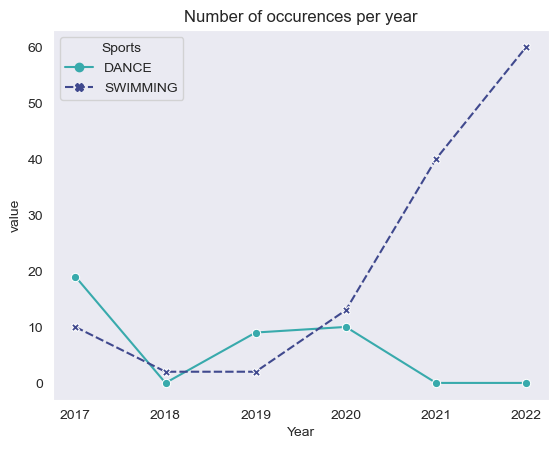

In [28]:
# Lineplot : Year
sns.set_style("dark")
palette = sns.color_palette("mako_r", 2)
sns.lineplot(data = sports_year, x= "Year", y= "value", hue = "Sports", ci= None,
             markers=True, style="Sports", palette = palette).set(title='Number of occurences per year')

<div class="alert alert-block alert-warning">
<b>Learnings:</b> 
My swimming and dancing activities seem to follow the same pattern from 2017 to 2019, and then start diverging drastically. Indeed, from 2017 to 2019, I was still a student so if I had time for one activity, I also had some time for the other. On the other hand, if I was too busy and working abroad, I generally had no time for neither swimming nor dancing (cf. low points in 2018).
    
When the Covid19 crisis broke out early 2020, I completely stopped taking dance classes. Indeed, the dance studios were shut down during a very long period, and I never went back (cf. 2021 and 2022 flat dashed purple lines). On the contrary, I increased dramatically the number of my swimming workouts (x6 increase between 2020 and 2022).
</div>

In [29]:
#MONTH ANALYSIS: For every month and every year, I count the number of times I went to the swimming pool and dance classes
sports_month = place_visits_df.groupby(['Year', 'Month', 'Sports']).size().unstack(fill_value=0)
sports_month.rename(columns={'DANCE': 'sport_DANCE', 'SWIMMING': 'sport_SWIMMING'}, inplace=True)
sports_month.reset_index(inplace=True)

sports_month = pd.wide_to_long(sports_month,
               stubnames=['sport'],
               i=['Year', 'Month'],
               j='Sports',
               sep = '_',
               suffix='.+')

sports_month.reset_index(inplace=True)
sports_month.rename(columns={'sport': 'value'}, inplace=True)
sports_month

,Year,Month,Sports,value
0,2017,1,DANCE,2
1,2017,1,SWIMMING,0
2,2017,2,DANCE,4
3,2017,2,SWIMMING,0
4,2017,3,DANCE,2
...,...,...,...,...
63,2022,8,SWIMMING,17
64,2022,9,DANCE,0
65,2022,9,SWIMMING,4
66,2022,10,DANCE,0


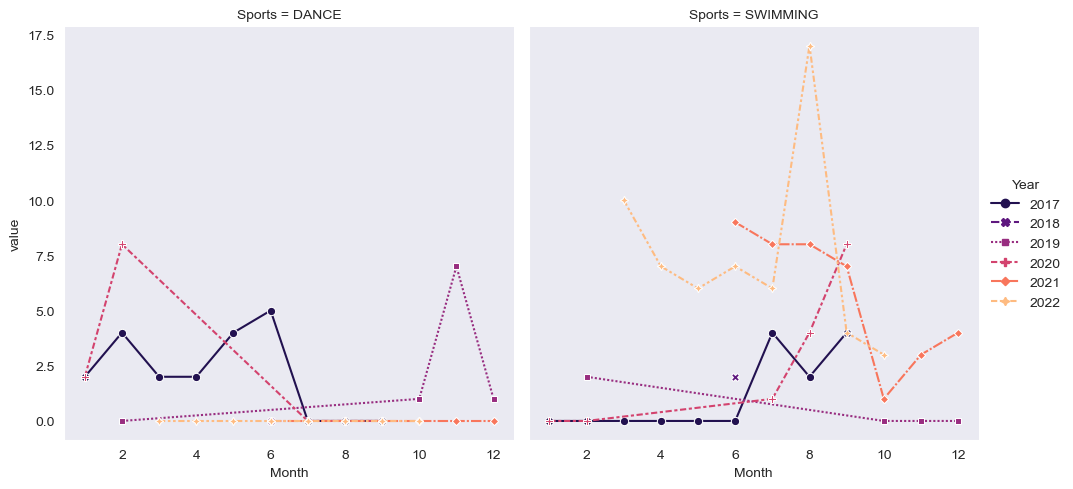

In [35]:
# Lineplot (monthly analysis)
sns.set_style("dark")
palette_6 = sns.color_palette("magma", 6)
sns.relplot(data = sports_month, x= "Month", y= "value", hue = "Year", ci= None,
            kind= "line", col="Sports",
             markers=True, style="Year", palette = palette_6)

<div class="alert alert-block alert-warning">
<b>Learnings:</b> 
My dancing lessons have been very erratic. I have been quite consistent during the first semester of 2017 (dark purple line), 
when I was taking KPop dance classes during my exchange in Singapore (2 to 3 times a month). Then I stopped and I tried to resume dance classes after finishing my studies at the end of 2019 (classes twice a week in November). But then I gave up due to 2 external events: i) the transportation strikes that took place in France in December 2019 and January 2020 that prevented me going to the dance studio, ii) the first Covid19 lockdown in earch March 2020.

Regarding swimming, some seasonality seems to be at play. I almost never go swimming during winter, and I most active in summer when there is no lockdown. Moreover, during summer, my nearby swimming pools close at 10PM (instead of 7PM) so it is more convenient to go after work. In August 2022, I reached my record: I went 18 times, i.e. every 1.5 days !
</div>

### 2) Workout durations <a class="anchor" id="7.2"></a>

In [31]:
# Compute the average time (in minutes) spent at the swimming pool / dance studio
place_visits_df.groupby(["Sports", "Year"])["duration_minutes"].mean()

Sports    Year
DANCE     2017    117.253164
          2019    106.997198
          2020    106.295742
SWIMMING  2017     70.542805
          2018     63.563200
          2019     52.293600
          2020     71.194932
          2021     76.415544
          2022     78.297432
Name: duration_minutes, dtype: float64

[Text(0.5, 1.0, 'Duration in minutes')]

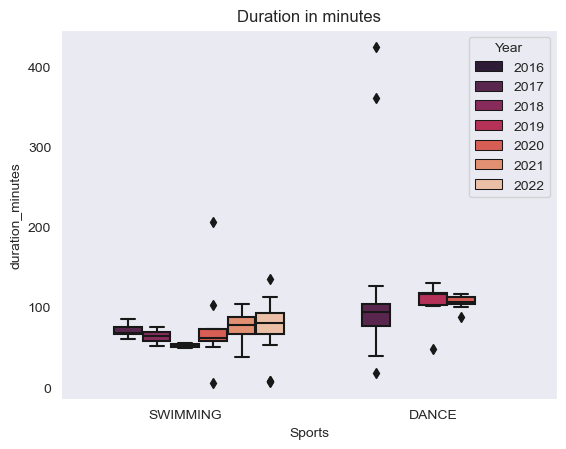

In [33]:
# Boxplot: Distribution time spent for each activity over time
sns.boxplot(data = place_visits_df, x="Sports", y= "duration_minutes", hue = "Year", palette = "rocket").set(title='Duration in minutes')

<div class="alert alert-block alert-warning">
<b>Learnings:</b> 
The duration of my workouts was pretty stable over time. On average, I spent 1 hour and a half at the dance studio.
This makes sense since my dance classes usually last 90 minutes. 
Regarding swimming, the duration of my workouts has slightly increased (52 minutes to 78 minutes on average between 2018 and 2022).
</div>

## Conclusion and next steps <a class="anchor" id="8"></a>

### Key learnings <a class="anchor" id="8.1"></a>

Thanks to Google Maps History Location data I could recover my swimming and dance workout history data. 
  
The results show that I have not been consistent in taking dance classes because lots of external events made me give up (moving, strikes, Covid19). On the contrary, I have pretty stuck to swimming (despite Covid19) and my workouts duration is quite stable over time.

From a technical point of view, this project made me work with deep nested JSON files. The learning curve was a bit steep at the beginning but then the data analysis and visualization was easier.

### Next steps <a class="anchor" id="8.2"></a>

My next steps are the following:
- Combine the Samsung Health pedometer data and Google Maps History location data to have the full perspective on my workouts (running, hiking, swimming, dancing)
- Combine the Samsung Health pedometer data and Google Maps History location data to provide more context on my pedometer data. The goal is to associate a zipcode / a city to each day I hiked quite a lot.
- To further investigate the activitySegments data by focusing on a hike trip I did: where did I go, taking which route, etc?

Thank you for reading !  

<img src="https://images.unsplash.com/photo-1461183479101-6c14cd5299c4?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=870&q=80" alt="Google Maps image" width="500" style="margin-left:0"/>  
Photo by <a href="https://unsplash.com/@stevep4?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Stephen Monroe</a> on <a href="https://unsplash.com/s/photos/route?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  